NBD/OTB - NBD with One-Time Buyers

Source:
- [A note on an integrated model of customer buying behavior](https://www.sciencedirect.com/science/article/abs/pii/S0377221701001655)
- [Spreadsheet to Accompany "A Note on an Integrated Model of Customer Buying Behavior"](http://www.brucehardie.com/notes/003/)
- [Counting your customers: Compounding customer’s in-store decisions, interpurchase time and repurchasing behavior](https://www.sciencedirect.com/science/article/abs/pii/S0377221799003264)
- [Illustrating the Performance of the NBD as a Benchmark Model for Customer-Base Analysis](https://www.brucehardie.com/notes/005/)
- [Revisiting Morrison's Series Approximation for Estimating the Parameters of the NBD](https://www.brucehardie.com/notes/046/)

In [1]:
import numpy as np
from scipy.optimize import minimize, newton
from scipy.special import gamma, factorial
from scipy.stats import chisquare, chi2

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [2]:
num_purchase, observed_freq, integrated_model = np.loadtxt(
    'data/Ten-Ren-Tea-Co-data.csv',
    dtype='int',
    delimiter=',',
    unpack=True,
    skiprows=1
)

In [17]:
def nbd_otb_pmf(x, r, alpha, omega): # P(X=x)
    # P_{NBD}(X=x) - NBD probability mass function
    P_nbd = gamma(r + x)/(gamma(r)*factorial(x)) * (alpha/(alpha+1))**r * (1/(alpha+1))**x
    # P(X=x) - aggregate distribution of purchases
    P_nbd_otb = (1-omega) * P_nbd
    P_nbd_otb[1] += omega
    return P_nbd_otb

def nbd_otb_params(x, f_x):
    def log_likelihood(params):
        r, alpha, omega = params
        return -np.sum(f_x * np.log(nbd_otb_pmf(x, r, alpha, omega)))
    return minimize(log_likelihood, x0=[0.1,0.1,0.1], bounds=[(1e-6, np.inf), (1e-6, np.inf), (0, 1)])

def nbd_otb_mean(r, alpha, omega):
    return omega + (1-omega) * (r/alpha)

def nbd_otb_var(r, alpha, omega):
    return (1-omega) * (r/alpha + r/alpha**2) + omega * (1-omega) * (r-alpha)**2 / (alpha**2)

def thiels_U(f_x, E_f_x):
    return np.sqrt(np.sum((f_x - E_f_x)**2) / np.sum(f_x**2))

# Conditional expectations such as E(X_2 | X_1 = x)
def nbd_otb_ce(x, r, alpha, omega):
    E_X2_X2_x = (r+x)/(alpha+1)
    E_X2_X2_x[1] *= 1 - omega/(omega + (1-omega)* r / (alpha+1)*(alpha/(alpha+1))**r)
    return E_X2_X2_x

**NBD/OTB:**

Parameter Estimates:
- $r$ = 0.5072
- $\alpha$ = 0.1224
- $\omega$ = 0.2028

Log-Likelihood = -3077.6850

Summary Stats: 
- $E(X)$ = 3.505
- $var(X)$ = 31.871
- Theil’s $U$ = 0.0465

Integrated Model's Theil’s $U$ = 0.0649

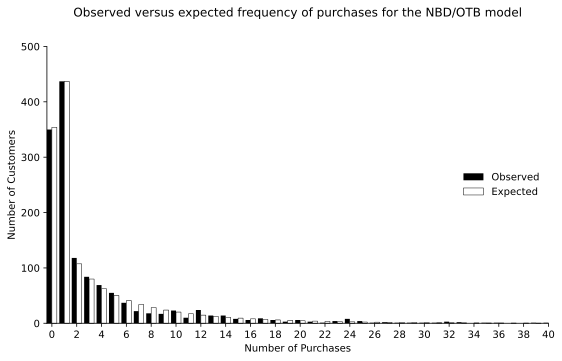

In [4]:
res = nbd_otb_params(num_purchase, observed_freq)
r, alpha, omega = res.x
ll = res.fun

expected_freq_nbd_otb = np.sum(observed_freq) * nbd_otb_pmf(num_purchase, r, alpha, omega)
U = thiels_U(observed_freq, expected_freq_nbd_otb)

display_markdown(f'''**NBD/OTB:**

Parameter Estimates:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}
- $\\omega$ = {omega:0.4f}

Log-Likelihood = {-ll:0.4f}

Summary Stats: 
- $E(X)$ = {nbd_otb_mean(r, alpha, omega):0.3f}
- $var(X)$ = {nbd_otb_var(r, alpha, omega):0.3f}
- Theil’s $U$ = {U:0.4f}

Integrated Model's Theil’s $U$ = {thiels_U(observed_freq, integrated_model):0.4f}''', raw=True)

bar_width = 0.4
plt.figure(figsize=(9,5), dpi=100)
plt.bar(num_purchase - bar_width / 2, observed_freq, width=bar_width, label='Observed', color='black')
plt.bar(num_purchase + bar_width / 2, expected_freq_nbd_otb, width=bar_width, label='Expected', color='white', edgecolor='black', linewidth=0.5)
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.title('Observed versus expected frequency of purchases for the NBD/OTB model', pad=30)
plt.xticks(num_purchase[::2], num_purchase[::2])
plt.ylim(0, 500)
plt.xlim(0-bar_width, 40)
plt.legend(loc=7, frameon=False);

Conditional Expectations for the NBD/OTB model

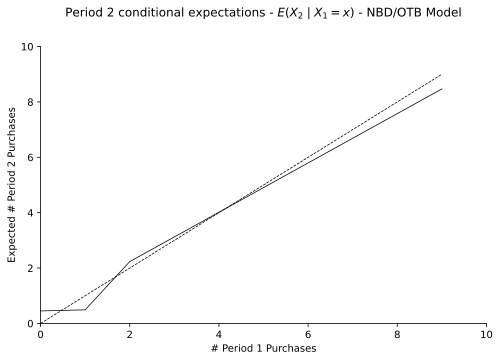

In [5]:
ce = nbd_otb_ce(num_purchase, r, alpha, omega)

plt.figure(figsize=(8,5), dpi=100)
plt.plot(num_purchase[:10], ce[:10], "k-", linewidth=0.75)
plt.plot(num_purchase[:10], num_purchase[:10], "k--", linewidth=0.75)
plt.xlabel("# Period 1 Purchases")
plt.ylabel("Expected # Period 2 Purchases")
plt.title('Period 2 conditional expectations - $E(X_2 \\mid X_1 = x)$ - NBD/OTB Model', pad=30)
plt.ylim(0,10)
plt.xlim(0, 10);

NBD

In [6]:
# NBD - MLE Method
def nbd_pmf(x, r, alpha):
    return gamma(r + x)/(gamma(r)*factorial(x)) * (alpha/(alpha+1))**r * (1/(alpha+1))**x

def nbd_params(x, f_x):
    def log_likelihood(params):
        r, alpha = params
        nbd = nbd_pmf(x, r, alpha)
        return -np.sum(f_x * np.log(nbd))
    return minimize(log_likelihood, x0=[0.1,0.1], bounds=[(1e-6,np.inf),(1e-6,np.inf)])

res = nbd_params(num_purchase, observed_freq)
r, alpha = res.x
ll = res.fun

expected_freq = np.sum(observed_freq) * nbd_pmf(num_purchase, r, alpha)
U = thiels_U(observed_freq, expected_freq)

display_markdown(f'''**NBD - MLE Method:**

Parameters:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}

Log-Likelihood = {-ll:0.4f}

Theil’s $U$ = {U:0.4f}''', raw=True)

**NBD - MLE Method:**

Parameters:
- $r$ = 0.5897
- $\alpha$ = 0.1682

Log-Likelihood = -3194.0455

Theil’s $U$ = 0.4087

In [7]:
# NBD - Method of Momemts
def nbd_mom_params(x, f_x):
    mean = np.sum(x * f_x)/np.sum(f_x)
    variance = np.sum(f_x * (x-mean)**2)/(np.sum(f_x)-1)
    alpha = mean / (variance-mean)
    r = alpha * mean
    return r, alpha

r, alpha = nbd_mom_params(num_purchase, observed_freq)

display_markdown(f'''**NBD - Method of Momemts:**

Parameter Estimates:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}''', raw=True)

**NBD - Method of Momemts:**

Parameter Estimates:
- $r$ = 0.4356
- $\alpha$ = 0.1243

In [8]:
# NBD - Mean and Zeroes Method
def nbd_mz_params(x, f_x):
    mean = np.sum(x * f_x)/np.sum(f_x)
    P_0 = f_x[0]/np.sum(f_x)
    P_X_0 = lambda alpha: (alpha/(alpha+1))**(alpha*mean) - P_0  # noqa: E731
    alpha = newton(P_X_0, x0=0)
    r = alpha * mean
    return r, alpha

r, alpha = nbd_mz_params(num_purchase, observed_freq)

display_markdown(f'''**NBD - Mean and Zeroes:**

Parameter Estimates:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}''', raw=True)

**NBD - Mean and Zeroes:**

Parameter Estimates:
- $r$ = 0.8178
- $\alpha$ = 0.2333

CNBD/OTB

The underlying CNBD probabilities are computed as follows:

`P_CNBD(X=x) = .5*(1-\delta{x,0}*P_NBD(X=2x-1) + P_NBD(X=2x) + .5*P_NBD(X=2x+1)`

where `\delta_{x,0} = 1 if x = 0; 0 otherwise`. The NBD probabilities are computed using the standard forward recursion.

In [9]:
def cnbd_otb_pmf(x, r, alpha, omega):
    P_X_x = nbd_pmf(np.arange(len(x)*2), r, alpha)
    P_X_2x_s1 = np.append([0], P_X_x[1:-1:2]) # P(X=2x-1) 
    P_X_2x = P_X_x[::2] # P(X=2x)
    P_X_2x_p1 = P_X_x[1::2] # P(X=2x+1)
    cnbd = 0.5*P_X_2x_s1 + P_X_2x + 0.5*P_X_2x_p1
    cnbd_otb = (1-omega)*cnbd
    cnbd_otb[1] += omega    
    return cnbd_otb

def cnbd_otb_params(x, f_x):
    def log_likelihood(params):
        r, alpha, omega = params
        cnbd_otb = cnbd_otb_pmf(x, r, alpha, omega)
        return -np.sum(f_x * np.log(cnbd_otb))
    
    return minimize(log_likelihood, x0=[0.1,0.1,0.1], bounds=[(1e-6, np.inf), (1e-6, np.inf), (0, 1)])

In [18]:
res = cnbd_otb_params(num_purchase, observed_freq)
r, alpha, omega = res.x
ll = res.fun

expected_freq_cnbd_otb = np.sum(observed_freq) * cnbd_otb_pmf(num_purchase, r, alpha, omega)
U = thiels_U(observed_freq, expected_freq_cnbd_otb)

display_markdown(f'''**NBD/OTB:**

Parameter Estimates:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}
- $\\omega$ = {omega:0.4f}

Log-Likelihood = {-ll:0.4f}

Theil’s $U$ = {U:0.4f}''', raw=True)

**NBD/OTB:**

Parameter Estimates:
- $r$ = 0.4602
- $\alpha$ = 0.0565
- $\omega$ = 0.1854

Log-Likelihood = -3076.8898

Theil’s $U$ = 0.0423

Evaluate the fit of the NBD/OTB, CNBD/OTB and Wu & Chen's integrated model on the basis of the chi-square goodness-of-fit test. To satisfy the requirements of the test (i.e., E(f_x) >= 5) for all three models (the NBD/OTB, CNBD/OTB, and "Integrated" models), we right-censor the data at x = 19.

We observe that the CNBD/OTB model provides a slightly better fit to the data than the NBD/OTB on the basis of log-likelihood (LL), the chi-square goodness-of-fit test, and Theil's U.

In [15]:
# Right-Censored Data
f_x = observed_freq[:19]
f_x = np.append(f_x, np.sum(observed_freq) - np.sum(f_x))

im_f_x = integrated_model[:19]
im_f_x = np.append(im_f_x, np.sum(observed_freq) - np.sum(im_f_x))

nbd_otb_f_x = expected_freq_nbd_otb[:19]
nbd_otb_f_x = np.append(nbd_otb_f_x, np.sum(observed_freq) - np.sum(nbd_otb_f_x))

cnbd_otb_f_x = expected_freq_cnbd_otb[:19]
cnbd_otb_f_x = np.append(cnbd_otb_f_x, np.sum(observed_freq) - np.sum(cnbd_otb_f_x))

test_stat_nbdotb, p_value_nbdotb = chisquare(f_x, nbd_otb_f_x, ddof=3)
critical_val_nbdotb = chi2.isf(0.05, df=16)

test_stat_cnbdotb, p_value_cnbdotb = chisquare(f_x, cnbd_otb_f_x, ddof=2)
critical_val_cnbdotb = chi2.isf(0.05, df=16)

test_stat_im, p_value_im = chisquare(f_x, im_f_x, ddof=17)
critical_val_im = chi2.isf(0.05, df=2)

display_markdown(f'''**NBD/OTB:**

- Test Statistics = {test_stat_nbdotb:.2f}
- df = {16}
- Critical Value = {critical_val_nbdotb:.3f}
- p-Value = {p_value_nbdotb:.3f}

**CNBD/OTB:**

- Test Statistics = {test_stat_cnbdotb:.2f}
- df = {17}
- Critical Value = {critical_val_cnbdotb:.3f}
- p-Value = {p_value_cnbdotb:.3f}

**Integrated Model:**

- Test Statistics = {test_stat_im:.2f}
- df = {2}
- Critical Value = {critical_val_im:.3f}
- p-Value = {p_value_im:.3f}''', raw=True)

**NBD/OTB:**

- Test Statistics = 24.77
- df = 16
- Critical Value = 26.296
- p-Value = 0.074

**CNBD/OTB:**

- Test Statistics = 23.35
- df = 17
- Critical Value = 26.296
- p-Value = 0.138

**Integrated Model:**

- Test Statistics = 51.63
- df = 2
- Critical Value = 5.991
- p-Value = 0.000